In [11]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from plotnine import *

In [2]:
ames = pd.read_csv("AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

# Question 1

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with lambda = 1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

## Linear Regression

In [3]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([-5.33822743e+18, -1.21674040e+20, -2.79619977e+20, -2.04234366e+19, -2.28658154e+17])

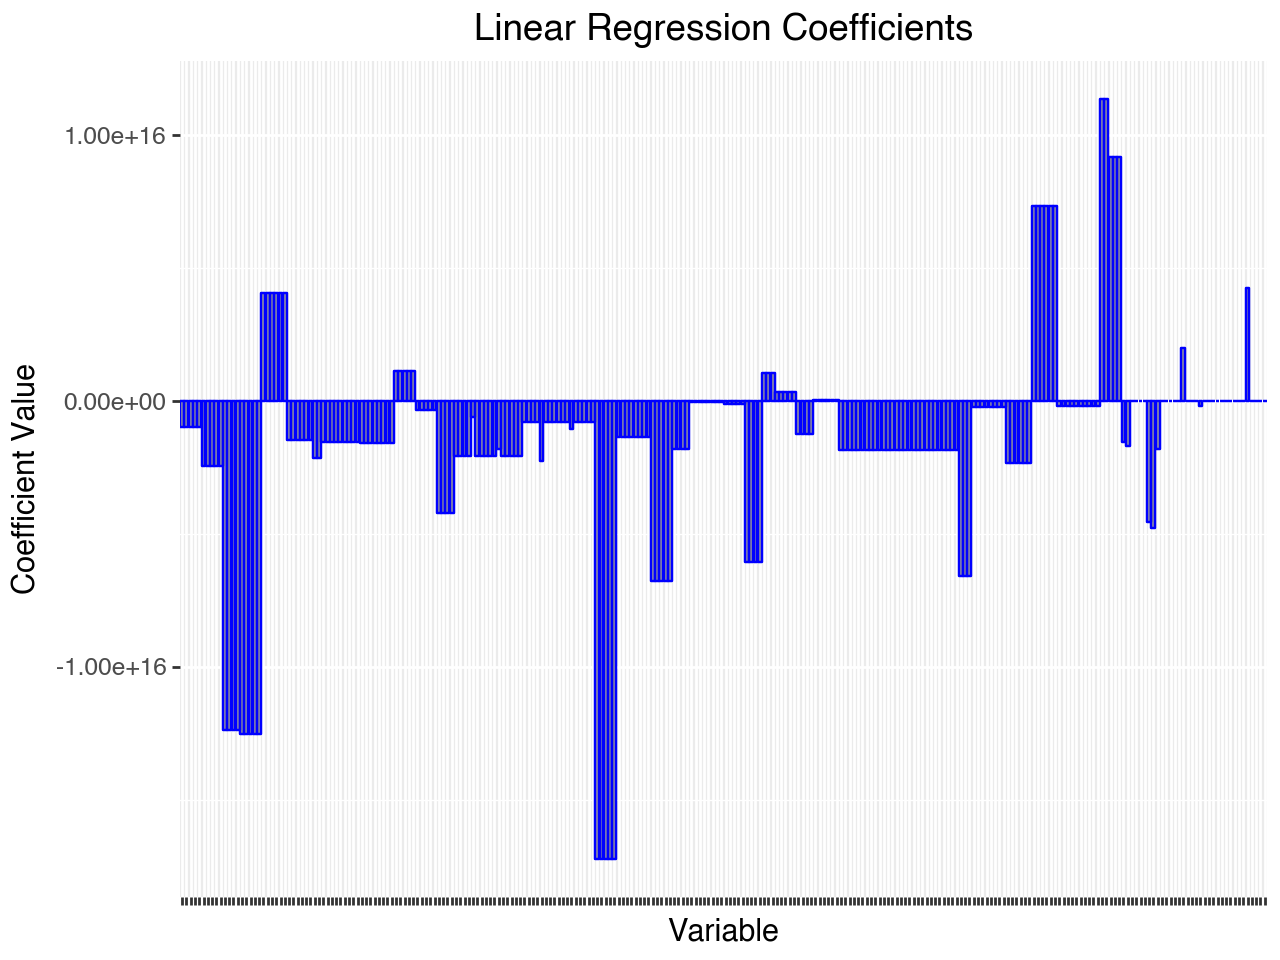

In [4]:
# linear regression plot
linear_fitted = lr_pipeline_1.fit(X, y)
linear_coefs = linear_fitted.named_steps['linear_regression'].coef_

column_names = linear_fitted.named_steps['preprocessing'].get_feature_names_out()

# create plot df

linear_plot = pd.DataFrame({
    "Variable": column_names,
    "Coefficients": linear_coefs
})

(
ggplot(linear_plot, aes(x='Variable', y='Coefficients')) 
+ geom_bar(stat='identity', color = "blue", alpha = 0.6)
+ labs(x = "Variable", y = "Coefficient Value", title = "Linear Regression Coefficients")
+ theme(axis_text_x=element_blank())
+ scale_y_continuous(labels=lambda x: ["{:.2e}".format(i) for i in x])
)


## Ridge Regression

In [7]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 1))]
)

cross_val_score(ridge_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([0.89815807, 0.91744024, 0.79493606, 0.78522563, 0.91389818])

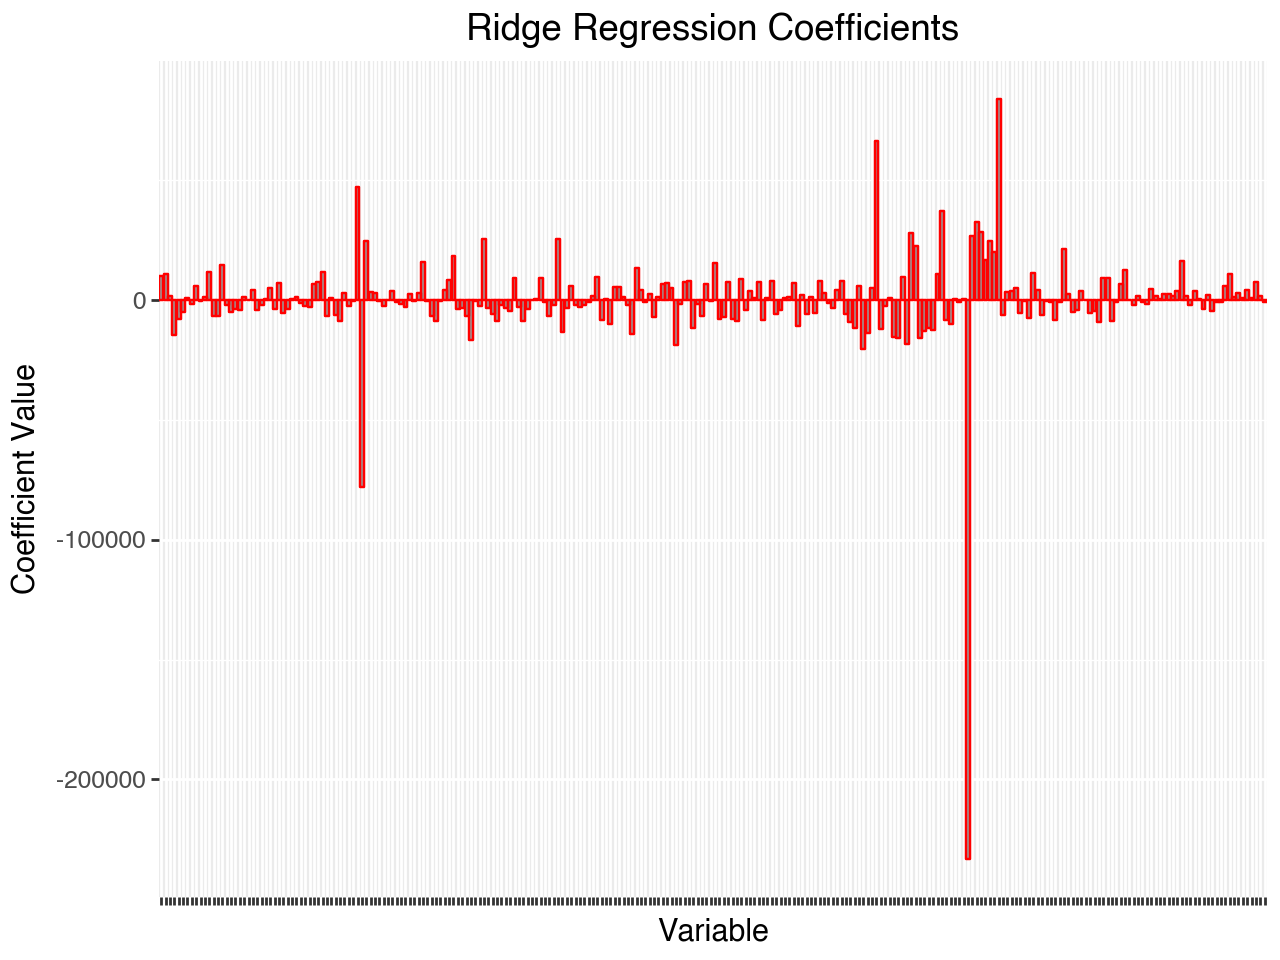

In [12]:
# ridge regession plot
# linear regression plot
ridge_fitted = ridge_pipeline_1.fit(X, y)
ridge_coefs = ridge_fitted.named_steps['ridge_regression'].coef_

column_names = ridge_fitted.named_steps['preprocessing'].get_feature_names_out()

# create plot df

ridge_plot = pd.DataFrame({
    "Variable": column_names,
    "Coefficients": ridge_coefs
})
(
ggplot(ridge_plot, aes(x='Variable', y='Coefficients')) 
+ geom_bar(stat='identity', color = "red", alpha = 0.6)
+ labs(x = "Variable", y = "Coefficient Value", title = "Ridge Regression Coefficients")
+ theme(axis_text_x=element_blank())
)

# Question 2

Using the same pipeline as previously, perform tuning on lambda.

You should always try lambda values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [13]:
ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

alphas = {"ridge_regression__alpha": [0.001, 0.01, 0.1, 1, 10]}

# Use GridSearchCV for tuning
grid_search = GridSearchCV(ridge_pipeline_1, alphas, cv=5, scoring='r2')

# Fit the model using cross-validation
grid_search_fitted = grid_search.fit(X, y)
print(grid_search_fitted.cv_results_['mean_test_score'])

# Best alpha and corresponding score
best_alpha = grid_search.best_params_['ridge_regression__alpha']
best_score = grid_search.best_score_

print(f"Best lambda: {best_alpha}")
print(f"Best cross-validated R² score: {best_score}")

[0.85392021 0.85418638 0.85630206 0.86193163 0.86427221]
Best lambda: 10
Best cross-validated R² score: 0.8642722110166746
[0.85392021 0.85418638 0.85630206 0.86193163 0.86427221]
Best lambda: 10
Best cross-validated R² score: 0.8642722110166746


# Question 3
Create a LASSO pipeline, and tune lambda.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [14]:
lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

lasso_alphas = {"lasso_regression__alpha": [0.001, 0.01, 0.1, 1, 10]}

# Use GridSearchCV for tuning
lasso_grid = GridSearchCV(lasso_pipeline_1, lasso_alphas, cv=5, scoring='r2')

# Fit the model using cross-validation
lasso_grid_fitted = lasso_grid.fit(X, y)
coef_lasso = lasso_grid.best_estimator_.named_steps['lasso_regression'].coef_
print(lasso_grid_fitted.cv_results_['mean_test_score'])

# Best alpha and corresponding score
best_alpha_lasso = lasso_grid.best_params_['lasso_regression__alpha']
best_score_lasso = lasso_grid.best_score_

print(f"Best lambda: {best_alpha_lasso}")
print(f"Best cross-validated R² score: {best_score_lasso}")

/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.569e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+10, tolerance: 1.477e+09


[0.85549892 0.85560578 0.85661828 0.85715222 0.86063224]
Best lambda: 10
Best cross-validated R² score: 0.8606322437321141
[0.85549892 0.85560578 0.85661828 0.85715222 0.86063224]
Best lambda: 10
Best cross-validated R² score: 0.8606322437321141


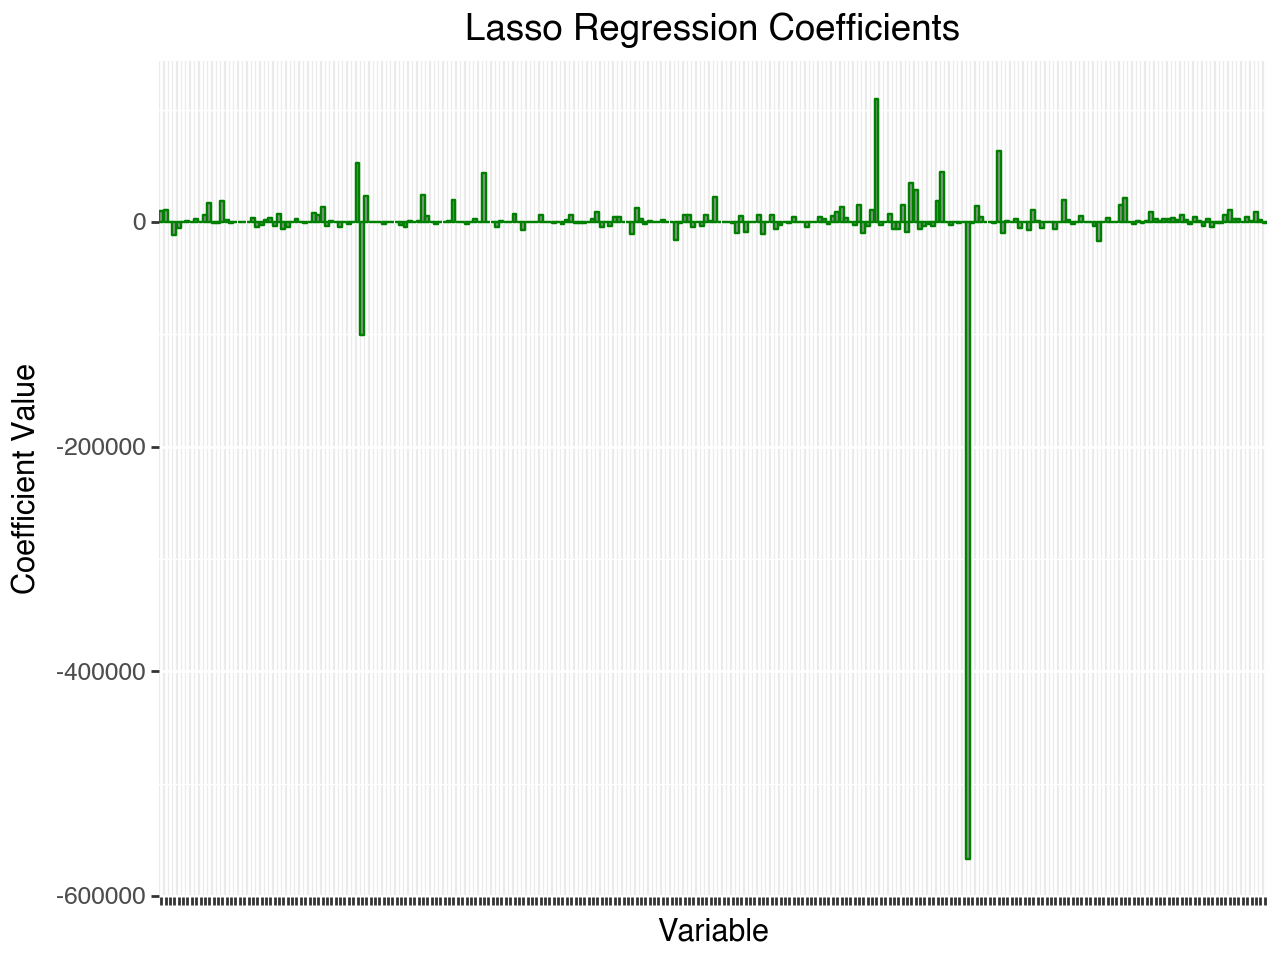

In [16]:

column_names = lasso_pipeline_1.named_steps['preprocessing'].get_feature_names_out()

# create plot df

lasso_plot = pd.DataFrame({
    "Variable": column_names,
    "Coefficients": coef_lasso
})
(
ggplot(lasso_plot, aes(x='Variable', y='Coefficients')) 
+ geom_bar(stat='identity', color = "green", alpha = 0.6)
+ labs(x = "Variable", y = "Coefficient Value", title = "Lasso Regression Coefficients")
+ theme(axis_text_x=element_blank())
)

# Question 4
Create an Elastic Net pipeline, and tune lambda and alpha.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [17]:
en_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("elastic_net_regression", ElasticNet())]
)

en_alphas = {"elastic_net_regression__alpha": [0.001, 0.01, 0.1, 1, 10],
                "elastic_net_regression__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]}

# Use GridSearchCV for tuning
en_grid = GridSearchCV(en_pipeline_1, en_alphas, cv=5, scoring='r2')

# Fit the model using cross-validation
en_grid_fitted = en_grid.fit(X, y)
print(en_grid_fitted.cv_results_['mean_test_score'])

# Best alpha and corresponding score
best_alpha_en = en_grid.best_params_['elastic_net_regression__alpha']
best_l1_ratio = en_grid.best_params_['elastic_net_regression__l1_ratio']
best_score_en = en_grid.best_score_

print(f"Best alpha: {best_alpha_en}")
print(f"Best l1_ratio: {best_l1_ratio}")
print(f"Best cross-validated R² score: {best_score_en}")

/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.517e+11, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.311e+11, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.147e+11, tolerance: 1.463e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.396e+11, tolerance: 1.407e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.286e+11, tolerance: 1.477e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.380e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.170e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.082e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.278e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.151e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.191e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.975e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.005e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.109e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.963e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.886e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.657e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.906e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.824e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.656e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.569e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.782e+11, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.645e+11, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.090e+11, tolerance: 1.463e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.465e+11, tolerance: 1.407e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.590e+11, tolerance: 1.477e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.429e+09, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.015e+10, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.603e+09, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.311e+09, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.608e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.375e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.099e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.468e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.330e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e+12, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.163e+12, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.783e+11, tolerance: 1.463e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.013e+11, tolerance: 1.407e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+12, tolerance: 1.477e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e+11, tolerance: 1.348e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e+11, tolerance: 1.474e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+11, tolerance: 1.463e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+11, tolerance: 1.407e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e+11, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e+12, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e+12, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e+12, tolerance: 1.463e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.790e+12, tolerance: 1.407e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e+12, tolerance: 1.477e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+10, tolerance: 1.477e+09


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.468e+12, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.860e+12, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.754e+12, tolerance: 1.463e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.545e+12, tolerance: 1.407e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.857e+12, tolerance: 1.477e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


[0.86319233 0.86281308 0.86215515 0.86064079 0.85549892 0.86368653 0.86405936 0.86426789 0.86405067 0.85560578 0.85162965 0.85403034 0.85698683 0.86088123 0.85661828
 0.81213194 0.82116844 0.8307003  0.84185231 0.85715222 0.53627566 0.59867086 0.67323913 0.75882319 0.86063224]
Best alpha: 0.01
Best l1_ratio: 0.5
Best cross-validated R² score: 0.8642678883652006
[0.86319233 0.86281308 0.86215515 0.86064079 0.85549892 0.86368653 0.86405936 0.86426789 0.86405067 0.85560578 0.85162965 0.85403034 0.85698683 0.86088123 0.85661828
 0.81213194 0.82116844 0.8307003  0.84185231 0.85715222 0.53627566 0.59867086 0.67323913 0.75882319 0.86063224]
Best alpha: 0.01
Best l1_ratio: 0.5
Best cross-validated R² score: 0.8642678883652006


/Users/chloefeehan/.conda/envs/pythonProject/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.064e+09, tolerance: 1.793e+09
